## Packages and Data

Read in and clean the 'Housing Price Gap' Data

In [137]:
import pandas as pd # Needed for reading csv
import numpy as np # Needed for setting : to nan
import matplotlib.pyplot as plt # For graphing
import seaborn as sns # For fancy plots
from matplotlib.lines import Line2D # For manual legend elements
import scipy.stats as sps # For means comparison# calculating VIF
# Functions for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sms # For regression
# For clustering
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.preprocessing import StandardScaler # For standardisation

In [138]:
raw_ratio = pd.read_csv('Data/House_Price_Wages_Ratio.csv', # Read in the csv for the ratio data
                        encoding = 'utf-8')
raw_ratio.columns

Index(['New Code', 'Old Code', 'Area', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [139]:
# Desired columns only
# Keep the "Old Code" becuase the tourism spend data doesn't have the new code
# This will allow a separate join on this column to work for this dataset

ratio = raw_ratio[['New Code','Old Code','Area','2019']].dropna().rename(columns={
    'New Code': 'Area_Code',
    'Old Code': 'Old_Code',
    '2019': 'House_Earnings_Ratio'})
ratio.head()

,Area_Code,Old_Code,Area,House_Earnings_Ratio
1,E09000001,00AA,City of London,:
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59


In [140]:
# Get rid of 'City of London' value, which has an NaN stored as ':'
ratio = ratio.drop(ratio[ratio.House_Earnings_Ratio == ':'].index)
# Get rid of 'London' from the bottom
ratio = ratio.drop(ratio[ratio.Area == 'London'].index)

ratio.head()

,Area_Code,Old_Code,Area,House_Earnings_Ratio
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59
6,E09000006,00AF,Bromley,10.73


In [141]:
# Convert the column to floats, so that it can be plotted
ratio['House_Earnings_Ratio'] = pd.to_numeric(ratio['House_Earnings_Ratio'])
ratio.dtypes

Area_Code                object
Old_Code                 object
Area                     object
House_Earnings_Ratio    float64
dtype: object

In [142]:
raw_rental = pd.read_excel('Data/Rental_Rates.xls', # Read in the excel sheet
                           sheet_name = 'Table2.7')
# There's loads of junk at the top, with the column headings I want on row five
# I save the row I want as a variable to assign as the index labels later
header_row = raw_rental.iloc[5]

In [143]:
# Drop the first five rows, including the row we want as the index labels, so its not repeated
rental_cleaned = raw_rental.drop(list(range(6)))
rental_cleaned.columns = header_row # Assign the row from before as index labels
rental_cleaned.head()

5,NaN,LA Code1,Area Code1,Area,Count of rents,Mean,Lower quartile,Median,Upper quartile
6,NaN,NaN,E92000001,ENGLAND,513900,852,550,700,950
7,NaN,NaN,E12000001,NORTH EAST,25770,533,420,495,595
8,NaN,1355,E06000047,County Durham UA,6200,492,395,450,525
9,NaN,1350,E06000005,Darlington UA,2520,490,395,450,550
10,NaN,724,E06000001,Hartlepool UA,890,479,400,470,550


In [144]:
# Pick out the desired columns and relabel them
# I must make sure all dataframes have the area codes stored under "Area_Code" for merging
rental_data = rental_cleaned[['Area Code1','Count of rents','Mean']].rename(columns={
    'Area Code1': 'Area_Code',
    'Count of rents':'Rent_Count',
    'Mean':'Rent_Price_Mean'})
rental_data.head()

# NOTE: This dataset includes all other administrative areas in the UK as well

5,Area_Code,Rent_Count,Rent_Price_Mean
6,E92000001,513900,852
7,E12000001,25770,533
8,E06000047,6200,492
9,E06000005,2520,490
10,E06000001,890,479


In [145]:
raw_open_space = pd.read_csv('Data/Open_Space.csv', # Read in the csv
                        encoding = 'utf-8')
raw_open_space.columns

Index(['Ward_GSS_CODE', 'Ward_NAME', 'BOROUGH_LB_GSS_CD', 'BOROUGH_Name',
       'Total area of ward (sq m)', 'All Open Space', '% open space',
       'Open Space with access', '% Open Space with access',
       '% of open space that has access'],
      dtype='object')

In [146]:
# Select desired columns and rename, keeping Area_Code consistent
open_space = raw_open_space[['Ward_GSS_CODE',
                             'Total area of ward (sq m)',
                             '% open space']].rename(columns={
    'Ward_GSS_CODE':'Area_Code',
    'Total area of ward (sq m)': 'Land_Area(m^2)',
    '% open space':'%Open_Space_2013'})
# I have to remove the commas in the land area data and convert it to a float
open_space['Land_Area(m^2)'] = open_space['Land_Area(m^2)'].str.replace(',','').astype('float')

In [147]:
open_space.head()

# NOTE: All the wards are in the dataframe as well, with the boroughs at the bottom
# The area code will serve as a unique identify for the boroughs and filter out the wards

,Area_Code,Land_Area(m^2),%Open_Space_2013
0,E05000026,1282926.0,21.9
1,E05000027,1364442.0,20.6
2,E05000028,1288085.0,1.9
3,E05000029,3384193.0,56.0
4,E05000030,3450576.0,50.4


In [148]:
raw_tourism_spend = pd.read_csv('Data/Tourism_Spend_2009.csv', # Read in the csv
                                encoding = 'utf-8')
raw_tourism_spend.columns

Index(['Code', 'Area', 'Overseas visitors (£ millions)',
       'Domestic visitors (£ millions)', 'Day visitors (£ millions)'],
      dtype='object')

In [149]:
# I need to sum the two values fir international and domestic spend together first
raw_tourism_spend.dtypes

Code                              object
Area                              object
Overseas visitors (£ millions)    object
Domestic visitors (£ millions)    object
Day visitors (£ millions)         object
dtype: object

In [150]:
tourism_spend_processed = raw_tourism_spend
tourism_spend_processed['Overseas visitors (£ millions)'] = tourism_spend_processed['Overseas visitors (£ millions)'].str.replace(',','').astype('float')
tourism_spend_processed['Domestic visitors (£ millions)'] = tourism_spend_processed['Domestic visitors (£ millions)'].str.replace(',','').astype('float')

In [151]:
tourism_spend_processed['Tourism_Spend_2009(£m)'] = sum((tourism_spend_processed['Overseas visitors (£ millions)'],
                                                    tourism_spend_processed['Domestic visitors (£ millions)']))
tourism_spend_processed.dtypes

Code                               object
Area                               object
Overseas visitors (£ millions)    float64
Domestic visitors (£ millions)    float64
Day visitors (£ millions)          object
Tourism_Spend_2009(£m)            float64
dtype: object

In [152]:
# Note, this has the old area codes
tourism_spend_2009 = raw_tourism_spend[['Code',
                             'Tourism_Spend_2009(£m)']].rename(columns={
    'Code':'Old_Code'})

## Data Joining

In [153]:
# Now I'm ready to start joining the data
y_with_tourism = ratio.merge(tourism_spend_2009, on='Old_Code', how='inner')
# Having joined on the old code, I can now get rid of it
y_with_tourism = y_with_tourism.drop('Old_Code', axis=1)
y_with_tourism.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m)
0,E09000002,Barking and Dagenham,10.75,57.0
1,E09000003,Barnet,14.19,186.0
2,E09000004,Bexley,9.61,106.0
3,E09000005,Brent,15.59,151.0
4,E09000006,Bromley,10.73,151.0


In [154]:
# I can now merge the other two dataframes on the Area_Code column
full_independents = y_with_tourism
# I can't do them both together with merge() so have to iterate
for df in [rental_data, open_space]: 
    full_independents = full_independents.merge(df,
                                                on = 'Area_Code',
                                                how = 'inner')

full_independents.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013
0,E09000002,Barking and Dagenham,10.75,57.0,880,1194,37799325.0,33.7
1,E09000003,Barnet,14.19,186.0,2160,1523,86748312.0,37.7
2,E09000004,Bexley,9.61,106.0,840,1106,64286458.0,38.9
3,E09000005,Brent,15.59,151.0,1620,1535,43232643.0,22.3
4,E09000006,Bromley,10.73,151.0,2700,1321,150134858.0,57.4


In [155]:
# I now need to calculate the number of rentals per square kilometer
full_independents['RentsKm^2'] = 1000000 * full_independents['Rent_Count'] / full_independents['Land_Area(m^2)']
full_independents.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013,RentsKm^2
0,E09000002,Barking and Dagenham,10.75,57.0,880,1194,37799325.0,33.7,23.280839
1,E09000003,Barnet,14.19,186.0,2160,1523,86748312.0,37.7,24.89962
2,E09000004,Bexley,9.61,106.0,840,1106,64286458.0,38.9,13.066516
3,E09000005,Brent,15.59,151.0,1620,1535,43232643.0,22.3,37.471685
4,E09000006,Bromley,10.73,151.0,2700,1321,150134858.0,57.4,17.983832


## Summary Statistics For Independent Variables

In [156]:
full_independents

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013,RentsKm^2
0,E09000002,Barking and Dagenham,10.75,57.0,880,1194,37799325.0,33.7,23.280839
1,E09000003,Barnet,14.19,186.0,2160,1523,86748312.0,37.7,24.89962
2,E09000004,Bexley,9.61,106.0,840,1106,64286458.0,38.9,13.066516
3,E09000005,Brent,15.59,151.0,1620,1535,43232643.0,22.3,37.471685
4,E09000006,Bromley,10.73,151.0,2700,1321,150134858.0,57.4,17.983832
5,E09000007,Camden,18.27,754.0,2400,2536,21789296.0,24.6,110.145826
6,E09000008,Croydon,10.97,193.0,2250,1136,86494436.0,32.2,26.013234
7,E09000009,Ealing,14.79,206.0,1210,1463,55544352.0,31.5,21.784393
8,E09000010,Enfield,12.34,159.0,1000,1310,82200191.0,48.5,12.165422
9,E09000011,Greenwich,12.72,116.0,1460,1404,50441943.0,39.3,28.944167


In [157]:
# Creates basic stats for any given set of input values
# Provide the data, the title, and the label for the y-axis on the boxplot
def summary_stats(data_col, label):
    
    data = full_independents[data_col]
    
    print(f'\nSummary Statistics for:\n\n{data_col}\n\n{data.describe()}\n') # Summary statistics
    print('Box Plot:\n')
    
    # Now I can plot the two years' distributions against each other
    fig, ax = plt.subplots(1,1, figsize = (4,7)) # Set axes and figure
    
    # Boxplot
    sns.boxplot(data = data,
                color = 'g',
                ax = ax)
    # Swarmplot over the top
    sns.swarmplot(data = data,
              color = 'black',
              size = 8,
              marker = 'd',
              alpha = 0.8,
              ax = ax)
    # Change the labels for the bars from default
    ax.set_xticklabels('')
    # Label the axes
    ax.set_ylabel(label, size = 15)
    # Set title
    plt.title(f'Boxplot & Swarmplot',
         size = 15)
    plt.show()
    # Save it to an output folder
    fig.savefig(f'Figures/Summary_States_{data_col}.png',
                bbox_inches = 'tight')


Summary Statistics for:

House_Earnings_Ratio

count    32.000000
mean     13.897187
std       3.520170
min       9.610000
25%      11.970000
50%      13.000000
75%      14.485000
max      27.640000
Name: House_Earnings_Ratio, dtype: float64

Box Plot:



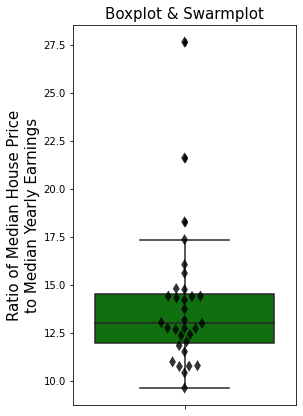

In [158]:
summary_stats('House_Earnings_Ratio',
              'Ratio of Median House Price\nto Median Yearly Earnings')


Summary Statistics for:

House_Earnings_Ratio

count    32.000000
mean     13.897187
std       3.520170
min       9.610000
25%      11.970000
50%      13.000000
75%      14.485000
max      27.640000
Name: House_Earnings_Ratio, dtype: float64

Box Plot:



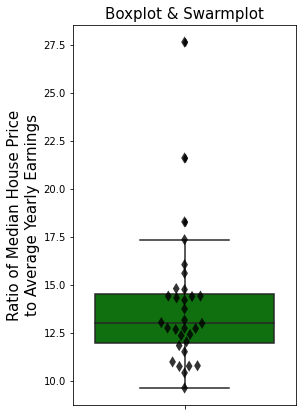


Summary Statistics for:

Tourism_Spend_2009(£m)

count      32.000000
mean      317.812500
std       602.590935
min        57.000000
25%       105.750000
50%       151.000000
75%       232.000000
max      3402.000000
Name: Tourism_Spend_2009(£m), dtype: float64

Box Plot:



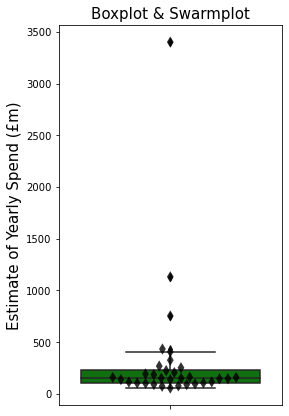


Summary Statistics for:

RentsKm^2

count     32.000000
unique    32.000000
top       23.280839
freq       1.000000
Name: RentsKm^2, dtype: float64

Box Plot:



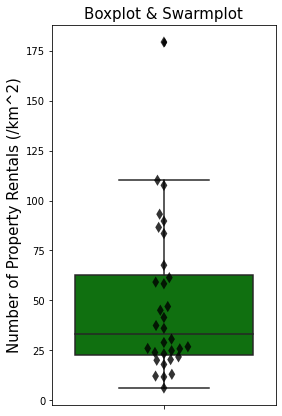


Summary Statistics for:

%Open_Space_2013

count    32.000000
mean     33.487500
std      11.064204
min      13.700000
25%      26.325000
50%      32.150000
75%      38.000000
max      59.000000
Name: %Open_Space_2013, dtype: float64

Box Plot:



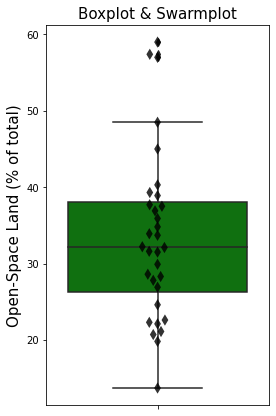

In [159]:
summary_stats('House_Earnings_Ratio',
              'Ratio of Median House Price\nto Average Yearly Earnings')

summary_stats('Tourism_Spend_2009(£m)',
              'Estimate of Yearly Spend (£m)')

summary_stats('RentsKm^2',
              'Number of Property Rentals (/km^2)')

summary_stats('%Open_Space_2013',
              'Open-Space Land (% of total)')

## Dependent Variables

In [160]:
# I can now read in the data needed to calculate my dependent variable(s)
# First, the income per borough for the those living in the borough
raw_redidents_earnings = pd.read_csv('Data/Earnings_Residents.csv', # Read in the csv
                                     encoding = 'utf-8')
raw_redidents_earnings.columns

Index(['Code', 'Area', '2002', 'Unnamed: 3', '2003', 'Unnamed: 5', '2004',
       'Unnamed: 7', '2005', 'Unnamed: 9', '2006', 'Unnamed: 11', '2007',
       'Unnamed: 13', '2008', 'Unnamed: 15', '2009', 'Unnamed: 17', '2010',
       'Unnamed: 19', '2011', 'Unnamed: 21', '2012', 'Unnamed: 23', '2013',
       'Unnamed: 25', '2014', 'Unnamed: 27', '2015', 'Unnamed: 29', '2016',
       'Unnamed: 31', '2017', 'Unnamed: 33', '2018', 'Unnamed: 35', '2019',
       'Unnamed: 37', '2020', 'Unnamed: 39'],
      dtype='object')

In [161]:
# Remove the unnamed columns (these are the confidence intervals we don't need)
residents_earnings_processed = raw_redidents_earnings.loc[:,~raw_redidents_earnings.columns.str.match('Unnamed')]
# Get rid of the head junk
residents_earnings_processed = residents_earnings_processed.drop([0,1,2])
residents_earnings_processed.head()

,Code,Area,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3,00AB,Barking and Dagenham,383.3,354.9,360.1,375.1,417.6,446.7,449.9,448.8,...,452.1,450.0,441.2,422.5,436.6,462.2,461.0,479.1,471.0,500.4
4,00AC,Barnet,427.4,450.1,453.3,442.3,466.1,460.0,502.2,528.1,...,498.3,503.1,517.5,479.1,491.0,485.6,522.6,536.6,536.4,520.2
5,00AD,Bexley,405.0,431.9,438.1,452.4,443.4,469.8,483.9,486.3,...,505.1,509.1,497.9,512.6,491.1,487.0,513.0,512.7,553.4,568.3
6,00AE,Brent,368.4,359.8,395.5,394.7,398.7,421.6,437.0,439.1,...,414.9,442.0,441.8,441.8,457.6,467.0,471.0,479.9,524.0,540.7
7,00AF,Bromley,440.1,449.2,461.2,464.8,479.5,506.3,546.0,545.6,...,551.7,566.6,581.1,578.5,583.8,584.3,608.0,632.7,638.3,608.4


In [162]:
# Put the column names into a list and slice off the first two
# This columnname list will work for our second dataframe as well
colnames_to_merge = residents_earnings_processed.columns.to_list()[2:]

In [163]:
# I need the dataframe to be "long" to calculate year by year
residents_earnings_long = pd.melt(residents_earnings_processed,
                                  id_vars = ['Area'],
                                  value_vars = colnames_to_merge, # This isn't strictly necessary!
                                  var_name = 'Year',
                                  value_name = 'Average_Pay_Residents(£)')
residents_earnings_long.head()

,Area,Year,Average_Pay_Residents(£)
0,Barking and Dagenham,2002,383.3
1,Barnet,2002,427.4
2,Bexley,2002,405.0
3,Brent,2002,368.4
4,Bromley,2002,440.1


In [164]:
# Same process for the earnings according to workplace
raw_workplace_earnings = pd.read_csv('Data/Earnings_Workplace.csv', # Read in the csv
                                     encoding = 'utf-8')
raw_workplace_earnings.head()

,Unnamed: 0,Unnamed: 1,1997,Unnamed: 3,1998,Unnamed: 5,1999,Unnamed: 7,2000,Unnamed: 9,...,2016,Unnamed: 41,2017,Unnamed: 43,2018,Unnamed: 45,2019,Unnamed: 47,2020,Unnamed: 49
0,Code,Area,number,conf %,number,conf %,number,conf %,number,conf %,...,number,conf %,number,conf %,number,conf %,number,conf %,number,conf %
1,E09000001,City of London,540.1,2.5,561.5,2.0,623.8,3.0,658.5,2.9,...,958.2,2.4,987.2,2.6,"1,054.1",2.9,"1,049.5",3.1,"1,103.1",3.9
2,E09000002,Barking and Dagenham,330.0,6.0,431.3,6.3,398.1,6.2,424.0,7.6,...,580.3,7.4,605.5,6.6,579.1,5.4,569.5,7.2,586.2,10.0
3,E09000003,Barnet,334.0,5.4,356.6,4.0,366.9,5.6,381.7,7.3,...,598.6,5.2,597.5,5.7,579.0,5.4,596.0,7.0,578.7,10.0
4,E09000004,Bexley,345.8,6.4,359.1,4.7,362.4,5.0,373.3,5.1,...,559.2,4.4,575.5,5.4,591.4,5.3,613.0,4.4,541.8,7.2


In [165]:
# I can't get rid of unnamed column this time as the columns for some important variables are on lower layers
# So I first rename the important ones
workplace_earnings_processed = raw_workplace_earnings.rename(columns={
    'Unnamed: 0': 'Code',
    'Unnamed: 1': 'Area',})
workplace_earnings_processed.head()

,Code,Area,1997,Unnamed: 3,1998,Unnamed: 5,1999,Unnamed: 7,2000,Unnamed: 9,...,2016,Unnamed: 41,2017,Unnamed: 43,2018,Unnamed: 45,2019,Unnamed: 47,2020,Unnamed: 49
0,Code,Area,number,conf %,number,conf %,number,conf %,number,conf %,...,number,conf %,number,conf %,number,conf %,number,conf %,number,conf %
1,E09000001,City of London,540.1,2.5,561.5,2.0,623.8,3.0,658.5,2.9,...,958.2,2.4,987.2,2.6,"1,054.1",2.9,"1,049.5",3.1,"1,103.1",3.9
2,E09000002,Barking and Dagenham,330.0,6.0,431.3,6.3,398.1,6.2,424.0,7.6,...,580.3,7.4,605.5,6.6,579.1,5.4,569.5,7.2,586.2,10.0
3,E09000003,Barnet,334.0,5.4,356.6,4.0,366.9,5.6,381.7,7.3,...,598.6,5.2,597.5,5.7,579.0,5.4,596.0,7.0,578.7,10.0
4,E09000004,Bexley,345.8,6.4,359.1,4.7,362.4,5.0,373.3,5.1,...,559.2,4.4,575.5,5.4,591.4,5.3,613.0,4.4,541.8,7.2


In [166]:
# Remove the confidence interval columns (these are the confidence intervals we don't need)
workplace_earnings_processed = workplace_earnings_processed.loc[:,~workplace_earnings_processed.columns.str.match('Unnamed')]
# One layer of head junk this time
workplace_earnings_processed = workplace_earnings_processed.drop([0])
workplace_earnings_processed.head()

,Code,Area,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,E09000001,City of London,540.1,561.5,623.8,658.5,691.0,719.6,736.0,777.8,...,969.2,919.7,945.2,928.0,926.2,958.2,987.2,"1,054.1","1,049.5","1,103.1"
2,E09000002,Barking and Dagenham,330.0,431.3,398.1,424.0,404.3,467.9,493.3,517.0,...,553.8,655.5,667.9,626.2,625.8,580.3,605.5,579.1,569.5,586.2
3,E09000003,Barnet,334.0,356.6,366.9,381.7,406.7,405.4,453.1,486.6,...,572.6,554.7,563.6,575.7,583.5,598.6,597.5,579.0,596.0,578.7
4,E09000004,Bexley,345.8,359.1,362.4,373.3,385.9,395.5,421.6,374.8,...,519.9,550.8,525.2,561.4,556.0,559.2,575.5,591.4,613.0,541.8
5,E09000005,Brent,334.0,362.5,366.4,407.9,402.0,403.1,430.4,431.6,...,512.6,537.3,546.4,561.7,574.9,572.8,575.0,581.8,644.5,670.5


In [167]:
# I need the dataframe to be "long" to calculate year by year
workplace_earnings_long = pd.melt(workplace_earnings_processed,
                                  id_vars = ['Code','Area'],
                                  value_vars = colnames_to_merge, # This isn't strictly necessary!
                                  var_name = 'Year',
                                  value_name = 'Average_Pay_Workplace(£)')
workplace_earnings_long.head()

,Code,Area,Year,Average_Pay_Workplace(£)
0,E09000001,City of London,2002,719.6
1,E09000002,Barking and Dagenham,2002,467.9
2,E09000003,Barnet,2002,405.4
3,E09000004,Bexley,2002,395.5
4,E09000005,Brent,2002,403.1


In [168]:
# Now I can merge the two and create the new variable
y_merged = workplace_earnings_long.merge(residents_earnings_long,
                                         on=['Area','Year'],
                                             # Both the borough and the year have to match
                                             # I have to use "Area" because the code is old
                                         how='inner')
y_merged.head()

,Code,Area,Year,Average_Pay_Workplace(£),Average_Pay_Residents(£)
0,E09000002,Barking and Dagenham,2002,467.9,383.3
1,E09000003,Barnet,2002,405.4,427.4
2,E09000004,Bexley,2002,395.5,405.0
3,E09000005,Brent,2002,403.1,368.4
4,E09000006,Bromley,2002,318.2,440.1


In [169]:
# Drop na rows and remove rows with na values
y_merged.dropna(subset = ['Average_Pay_Workplace(£)','Average_Pay_Residents(£)'])
y_merged['Average_Pay_Workplace(£)'] = y_merged['Average_Pay_Workplace(£)'].astype('float')
y_merged['Average_Pay_Residents(£)'] = y_merged['Average_Pay_Residents(£)'].astype('float')
# I also want the year stored as an integer for the graph
y_merged['Year'] = y_merged['Year'].astype('int')
# Create new column
y_merged['Residents_to_Workplace_Ratio'] = y_merged['Average_Pay_Residents(£)'] / y_merged['Average_Pay_Workplace(£)']
y_merged.head()

,Code,Area,Year,Average_Pay_Workplace(£),Average_Pay_Residents(£),Residents_to_Workplace_Ratio
0,E09000002,Barking and Dagenham,2002,467.9,383.3,0.819192
1,E09000003,Barnet,2002,405.4,427.4,1.054267
2,E09000004,Bexley,2002,395.5,405.0,1.024020
3,E09000005,Brent,2002,403.1,368.4,0.913917
4,E09000006,Bromley,2002,318.2,440.1,1.383092


In [170]:
# I now need to get rid of non-London areas
y_merged = y_merged[y_merged['Code'].str.contains('E09') == True]

<AxesSubplot:xlabel='Year', ylabel='Residents_to_Workplace_Ratio'>

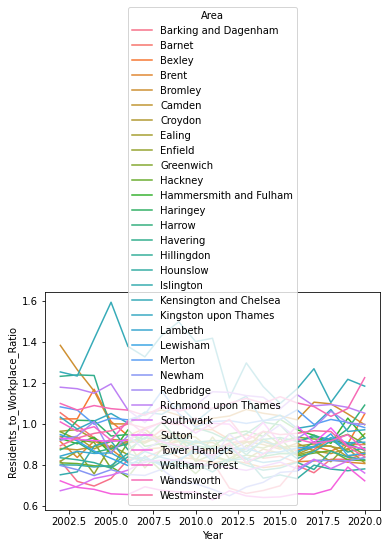

In [171]:
sns.lineplot(data=y_merged,
             x='Year',
             y='Residents_to_Workplace_Ratio',
             hue='Area')

In [172]:
change_since_2002 = y_merged[(y_merged['Year'] == 2002) | (y_merged['Year'] == 2019)]
change_since_2002.head()

,Code,Area,Year,Average_Pay_Workplace(£),Average_Pay_Residents(£),Residents_to_Workplace_Ratio
0,E09000002,Barking and Dagenham,2002,467.9,383.3,0.819192
1,E09000003,Barnet,2002,405.4,427.4,1.054267
2,E09000004,Bexley,2002,395.5,405.0,1.024020
3,E09000005,Brent,2002,403.1,368.4,0.913917
4,E09000006,Bromley,2002,318.2,440.1,1.383092


In [173]:
# Now I can pivot the table so I can create a 'difference' column
ratio_difference = change_since_2002.pivot(index = 'Code',
                                               # So 'Code' is kept (but I don't want it as the index ultimately)
                                           columns = 'Year', # Break apart the 'Year' column
                                           # I want the code as a column, not the index
                                           values = 'Residents_to_Workplace_Ratio').reset_index()
ratio_difference = ratio_difference.rename(columns={
    'Code': 'Area_Code',
    2002:'rtw_earnings_ratio_02',
    2019:'rtw_earnings_ratio_19'})
ratio_difference.columns                            

Index(['Area_Code', 'rtw_earnings_ratio_02', 'rtw_earnings_ratio_19'], dtype='object', name='Year')

In [174]:
# Calculate the new column with the percentage change of the ratio of average residents' earnings to average workers' earnings
ratio_difference['rtw_earnings_ratio_change_02-19'] = 100 * (ratio_difference['rtw_earnings_ratio_19'] - ratio_difference['rtw_earnings_ratio_02']) / ratio_difference['rtw_earnings_ratio_02']
ratio_difference.head()

Year,Area_Code,rtw_earnings_ratio_02,rtw_earnings_ratio_19,rtw_earnings_ratio_change_02-19
0,E09000002,0.819192,0.827041,0.958155
1,E09000003,1.054267,0.900000,-14.632663
2,E09000004,1.024020,0.902773,-11.840292
3,E09000005,0.913917,0.813033,-11.038614
4,E09000006,1.383092,1.048456,-24.194798


In [175]:
# Now I can merge this value to the big dataframe
full_data = full_independents.merge(ratio_difference,
                                    on = 'Area_Code', # Join this column
                                    how = 'inner') # Keep only the shared rows
full_data.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013,RentsKm^2,rtw_earnings_ratio_02,rtw_earnings_ratio_19,rtw_earnings_ratio_change_02-19
0,E09000002,Barking and Dagenham,10.75,57.0,880,1194,37799325.0,33.7,23.280839,0.819192,0.827041,0.958155
1,E09000003,Barnet,14.19,186.0,2160,1523,86748312.0,37.7,24.89962,1.054267,0.900000,-14.632663
2,E09000004,Bexley,9.61,106.0,840,1106,64286458.0,38.9,13.066516,1.024020,0.902773,-11.840292
3,E09000005,Brent,15.59,151.0,1620,1535,43232643.0,22.3,37.471685,0.913917,0.813033,-11.038614
4,E09000006,Bromley,10.73,151.0,2700,1321,150134858.0,57.4,17.983832,1.383092,1.048456,-24.194798


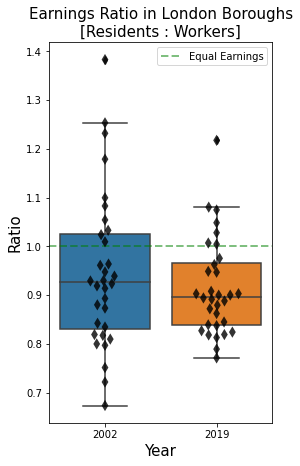

In [176]:
# Now I can plot the two years' distributions against each other
fig, ax = plt.subplots(1,1, figsize = (4,7)) # Set axes and figure

# Boxplot
sns.boxplot(data = full_data[['rtw_earnings_ratio_02','rtw_earnings_ratio_19']],
            ax = ax)
# Swarmplot over the top
sns.swarmplot(data = full_data[['rtw_earnings_ratio_02','rtw_earnings_ratio_19']],
              color = 'black',
              size = 8,
              marker = 'd',
              alpha = 0.8,
              ax = ax)
# Horizontal line for y=1
plt.axhline(y = 1,
            color='g',
            linestyle='--',
            lw = 2,
            alpha = 0.5)
# Legend (assign 2D Line to match the line on the graph)
plt.legend(handles = [Line2D([0],[0], linewidth = 2, # The axis line
                             linestyle = '--',
                             color = 'g',
                             alpha = 0.5)],
           labels = ['Equal Earnings']) # Label
# Change the labels for the bars from default
ax.set_xticklabels(['2002','2019'])
# Label the axes
ax.set_xlabel('Year', size = 15)
ax.set_ylabel('Ratio', size = 15)
# Set title
plt.title('Earnings Ratio in London Boroughs\n[Residents : Workers]',
         size = 15)
plt.show()
# Save it to an output folder
fig.savefig('Figures/Earnings_Ratio.png')

## Means Comparison Test

In [177]:
# I need to check there's a real difference between the two distributions
data1 = full_data['rtw_earnings_ratio_02']
data2 = full_data['rtw_earnings_ratio_19']

min1 = data1.min()
min2 = data2.min()

max1 = data1.max()
max2 = data2.max()

mean1 = data1.mean()
mean2 = data2.mean()
# Standard deviations
std1 = data1.std()
std2 = data2.std()

n1 = len(data1)
n2 = len(data2)

In [178]:
# Step 1

# H0: Mean of population 1 =  Mean of population 1
# H1: Mean of population 1 <> Mean of population 1

# Step 2

alpha = 0.05

In [179]:
std_ratio = std1/std2

print("std_ratio =", std_ratio)

if std_ratio > 0.5 and std_ratio < 2:
    print("Can assume equal population standard deviations.")
    equal_stds = True
else:
    print("Cannot assume equal population standard deviations.")
    equal_stds = False

std_ratio = 1.6060926323043345
Can assume equal population standard deviations.


In [180]:
# Calculate the test statistic and the p-value:
# (We don't actually need the test statistic, since it is only used to calculate the p-value anyway.)

# sps.test_ind gives TWO outputs
test_stat, p_value = sps.ttest_ind(data1, data2, equal_var = equal_stds)
print("p-value =", p_value)

p-value = 0.3447197449431806


In [181]:
# Reach a conclusion:

if p_value < alpha:
    print("p-value < significance threshold.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same mean.


## KS Distribution Test

In [182]:
# H0: Sample 1 and Sample 2 are drawn from identical distributions.
# H1: Sample 1 and Sample 2 are not drawn from identical distributions.

In [183]:
# Set significance level:

alpha = 0.05

In [184]:
# Likewise, gives two outputs
KS_stat, p_value = sps.ks_2samp(data1,data2)

# Compare with the KS stat we calculated earlier:

print("KS stat =", KS_stat)
print("p-value =", p_value)

KS stat = 0.25
p-value = 0.2730080624498207


In [185]:
# Reach a conclusion:

if p_value < alpha:
    print("p-value < significance threshold.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different distributions.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same distribution.")

p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same distribution.


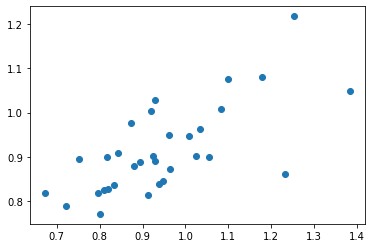

In [186]:
plt.scatter(data1, data2)

## Simple Regression

In [187]:
# Set up VIF Function
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
                            for i in range(df_with_const.shape[1])], name= "VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [188]:
full_data.dtypes

Area_Code                           object
Area                                object
House_Earnings_Ratio               float64
Tourism_Spend_2009(£m)             float64
Rent_Count                          object
Rent_Price_Mean                     object
Land_Area(m^2)                     float64
%Open_Space_2013                   float64
RentsKm^2                           object
rtw_earnings_ratio_02              float64
rtw_earnings_ratio_19              float64
rtw_earnings_ratio_change_02-19    float64
dtype: object

In [189]:
# I need all the data to be floats
for column in full_data.columns[2:]:
    full_data[column] = full_data[column].astype('float')
full_data.dtypes

Area_Code                           object
Area                                object
House_Earnings_Ratio               float64
Tourism_Spend_2009(£m)             float64
Rent_Count                         float64
Rent_Price_Mean                    float64
Land_Area(m^2)                     float64
%Open_Space_2013                   float64
RentsKm^2                          float64
rtw_earnings_ratio_02              float64
rtw_earnings_ratio_19              float64
rtw_earnings_ratio_change_02-19    float64
dtype: object

In [190]:
full_data['log_Tourism_Spend_2009(£m)'] = np.log(full_data['Tourism_Spend_2009(£m)'])
full_data['log_RentsKm^2'] = np.log(full_data['RentsKm^2'])

In [191]:
# Define the names of the x-variable columns
x_variables = ['rtw_earnings_ratio_19',
               'log_Tourism_Spend_2009(£m)',
               'log_RentsKm^2',
               '%Open_Space_2013',
               'rtw_earnings_ratio_change_02-19']

In [192]:
def simple_regression(variable, remove_outliers = False):
    
    # Prepare data
    print(f'\nFor {variable}:\n')
    x_values = full_data[variable]
    y_values = full_data['House_Earnings_Ratio']
    X_values = sms.add_constant(x_values)
    
    # Remove outliers
    if remove_outliers == True:
        removed_values = []
        stdev = x_values.std()
        limit = 4 * stdev # Value set higher than Tukey Fences
        mean = x_values.mean()
        fences = [mean - limit, mean + limit]
        for i in range(0,len(x_values)):
            if (x_values[i] < fences[0]) | (x_values[i] > fences[1]):
                x_values = x_values.drop([i])
                y_values = y_values.drop([i])
                print(f'...Removing {full_data.Area[i]}')
                removed_values.append(i)
        print(f'\nRemoved {len(removed_values)} outlier(s)\n')
    
    X_values = sms.add_constant(x_values)
    
    #R egression
    regression_model = sms.OLS(y_values, X_values).fit()
    print(regression_model.summary())
    
    # Summary
    gradient  = regression_model.params[1]
    intercept = regression_model.params[0]
    Rsquared  = regression_model.rsquared
    MSE       = regression_model.mse_resid
    pvalue    = regression_model.f_pvalue
    print("gradient  =", gradient)
    print("intercept =", intercept)
    print("Rsquared  =", Rsquared)
    print("MSE       =", MSE)
    print("pvalue    =", pvalue)
    
    # Line of best fit
    x_lobf = [min(x_values),max(x_values)]
    y_lobf = [x_lobf[0]*gradient + intercept,x_lobf[1]*gradient + intercept]
    
    # Plot
    fig, ax = plt.subplots(1,1, figsize = (7,7))
    plt.plot(x_values,y_values,
             'g.',
             x_lobf,y_lobf,
             'r--',
             markersize=10)
    plt.xlabel(variable)
    plt.ylabel('House Price to Yearly Earnings Ratio')
    plt.title(f'Scatter Plot with Best Fit Line for {variable}')
    print('\n\n\n') # Gap before next variable
    
    # Residual Plot
    ax2 = fig.add_axes([1, 0.15, 0.6, 0.6])
    plt.scatter(regression_model.fittedvalues,
                regression_model.resid,
                c='r', s=10)
    # Adding title and labels
    plt.xlabel(f'Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted Plot for {variable}')
    fig.savefig(f'Figures/{variable}_Simple_Reg.png')
    plt.show()


For rtw_earnings_ratio_19:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.186
Model:                              OLS   Adj. R-squared:                  0.159
Method:                   Least Squares   F-statistic:                     6.855
Date:                  Tue, 18 Jan 2022   Prob (F-statistic):             0.0137
Time:                          11:30:53   Log-Likelihood:                -81.878
No. Observations:                    32   AIC:                             167.8
Df Residuals:                        30   BIC:                             170.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


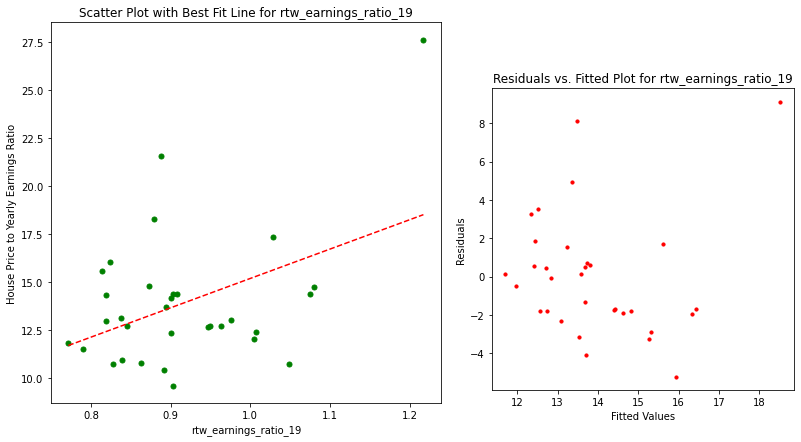


For log_Tourism_Spend_2009(£m):


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.533
Model:                              OLS   Adj. R-squared:                  0.517
Method:                   Least Squares   F-statistic:                     34.24
Date:                  Tue, 18 Jan 2022   Prob (F-statistic):           2.12e-06
Time:                          11:30:53   Log-Likelihood:                -72.989
No. Observations:                    32   AIC:                             150.0
Df Residuals:                        30   BIC:                             152.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


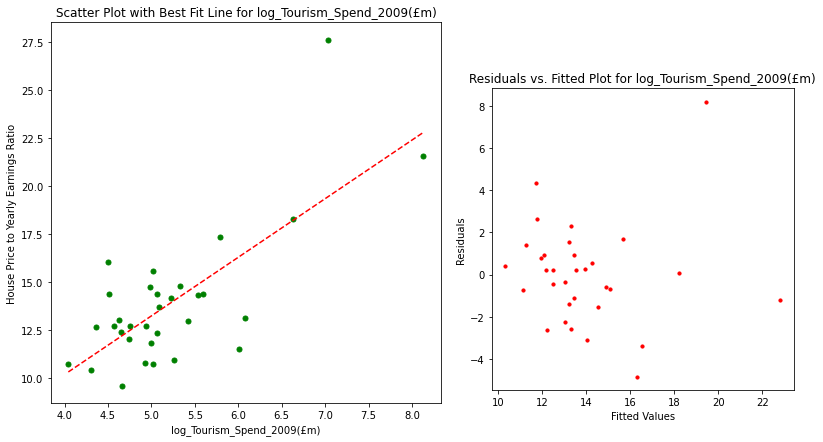


For log_RentsKm^2:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.472
Model:                              OLS   Adj. R-squared:                  0.454
Method:                   Least Squares   F-statistic:                     26.78
Date:                  Tue, 18 Jan 2022   Prob (F-statistic):           1.42e-05
Time:                          11:30:54   Log-Likelihood:                -74.964
No. Observations:                    32   AIC:                             153.9
Df Residuals:                        30   BIC:                             156.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


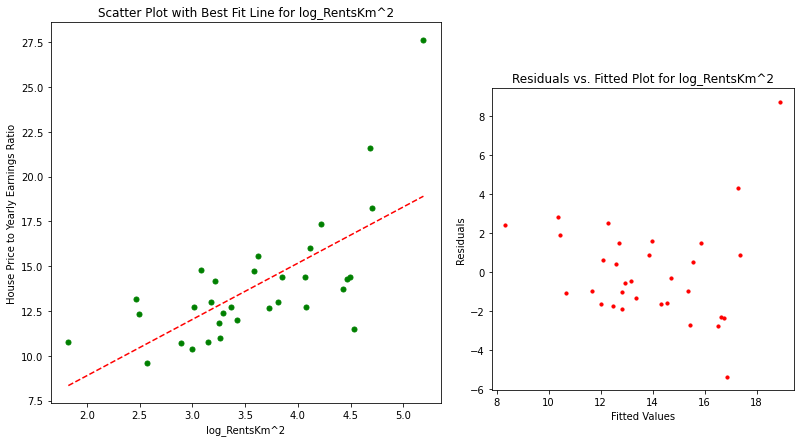


For %Open_Space_2013:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.202
Model:                              OLS   Adj. R-squared:                  0.175
Method:                   Least Squares   F-statistic:                     7.580
Date:                  Tue, 18 Jan 2022   Prob (F-statistic):            0.00992
Time:                          11:30:54   Log-Likelihood:                -81.566
No. Observations:                    32   AIC:                             167.1
Df Residuals:                        30   BIC:                             170.1
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


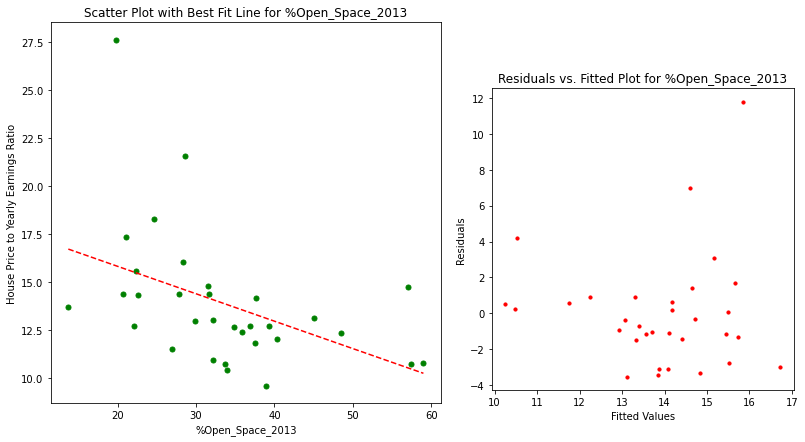


For rtw_earnings_ratio_change_02-19:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.029
Model:                              OLS   Adj. R-squared:                 -0.003
Method:                   Least Squares   F-statistic:                    0.9086
Date:                  Tue, 18 Jan 2022   Prob (F-statistic):              0.348
Time:                          11:30:54   Log-Likelihood:                -84.693
No. Observations:                    32   AIC:                             173.4
Df Residuals:                        30   BIC:                             176.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


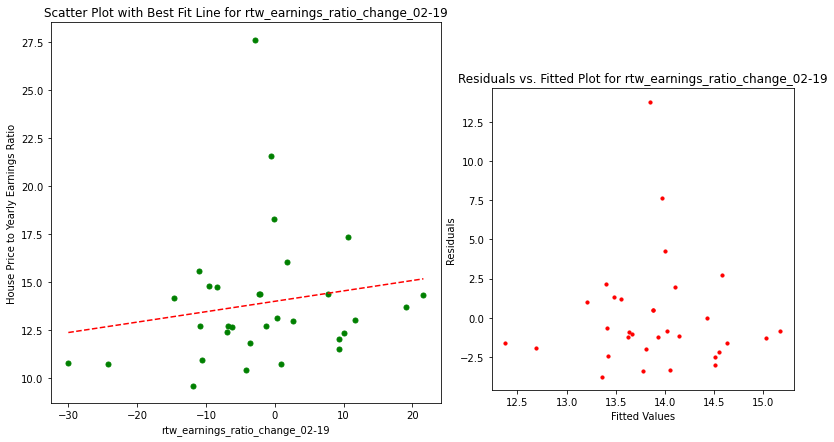

In [193]:
for x in x_variables:
    simple_regression(x, remove_outliers = True)

## Multiple Regression

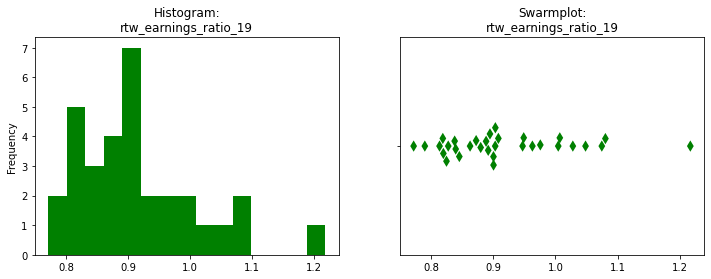

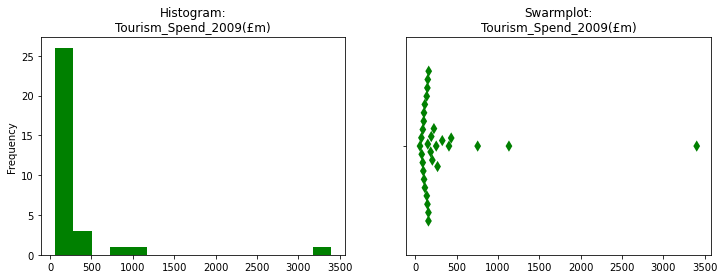

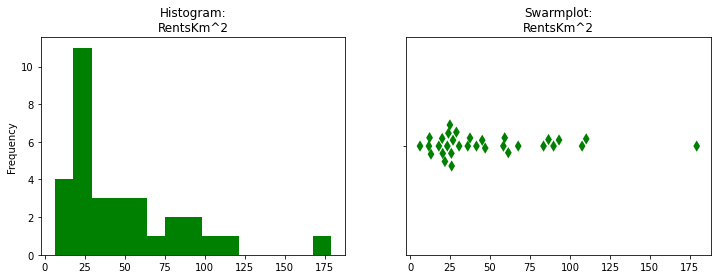

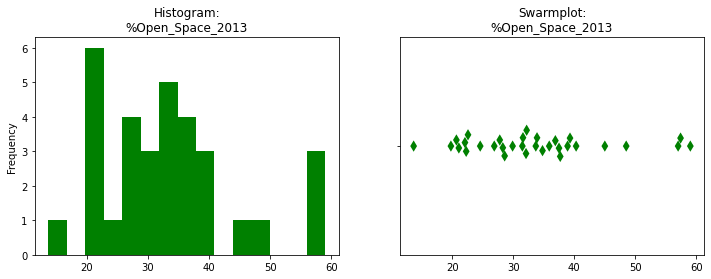

In [194]:
# Define the names of the x-variable columns
x_variables = ['rtw_earnings_ratio_19',
               #'rtw_earnings_ratio_change_02-19',
               'Tourism_Spend_2009(£m)',
               'RentsKm^2',
               '%Open_Space_2013']

for variable in x_variables:
    
    data = full_data[variable]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    plt.sca(ax1)
    plt.hist(data, color='g', bins=15)
    plt.title(f'Histogram:\n{variable}')
    plt.ylabel('Frequency')
    
    sns.swarmplot(data = data,
                  color = 'g',
                  size = 8,
                  marker = 'd',
                  orient='h',
                  ax = ax2)
    # Horizontal line for y=1
    plt.sca(ax2)
    plt.axhline(y = 1,
                color='g',
                linestyle='--',
                lw = 2,
                alpha = 0.5)
    # Set title
    plt.title(f'Swarmplot:\n{variable}')
    ax2.set_yticklabels('')
    plt.show()
    fig.savefig(f'Figures/{variable}_Distribution_Unlogged.png')

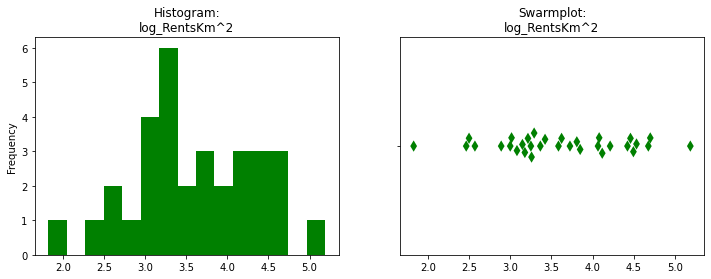

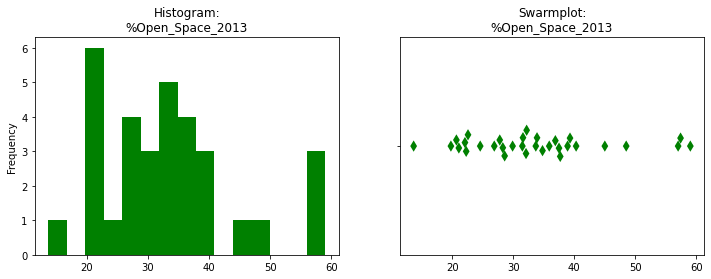

In [195]:
x_variables = [#'rtw_earnings_ratio_19',
               'log_Tourism_Spend_2009(£m)',
               'log_RentsKm^2',
               '%Open_Space_2013']

for variable in [x_variables[1],x_variables[2]]:
    
    data = full_data[variable]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    plt.sca(ax1)
    plt.hist(data, color='g', bins=15)
    plt.title(f'Histogram:\n{variable}')
    plt.ylabel('Frequency')
    
    sns.swarmplot(data = data,
                  color = 'g',
                  size = 8,
                  marker = 'd',
                  orient='h',
                  ax = ax2)
    # Horizontal line for y=1
    plt.sca(ax2)
    plt.axhline(y = 1,
                color='g',
                linestyle='--',
                lw = 2,
                alpha = 0.5)
    # Set title
    plt.title(f'Swarmplot:\n{variable}')
    ax2.set_yticklabels('')
    plt.show()
    fig.savefig(f'Figures/{variable}_Distribution_Logged.png')

In [196]:
def multiple_regression(predictors):
                       
    predictors_with_VIF = drop_column_using_vif(full_data[predictors])
    print(f'Predictors Included In Model After VIF:\n\n{list(predictors_with_VIF.columns)}\n')
    
    y_values = full_data['House_Earnings_Ratio']
    X_values = sms.add_constant(predictors_with_VIF)
    regression_model = sms.OLS(y_values, X_values).fit()
    # and print a summary of the results:
    print(regression_model.summary())
    print() # blank line

    # Now we store all the relevant values:
    predictor_coeffs  = regression_model.params[1:]
    constant          = regression_model.params[0] # called the 'intercept' in simple regression
    Rsquared          = regression_model.rsquared
    MSE               = regression_model.mse_resid
    pvalues_T         = regression_model.pvalues[1:]
    pvalue_F          = regression_model.f_pvalue

    # Note that predictor_coeffs is a list of the best-fit coefficients for x1, x2, x3, ...
    # Similarly, pvalues_T is a list of the p-values associated with each of these variables in turn.

    # Print these summary stats:
    print("predictor coefficients =", predictor_coeffs)
    print("constant               =", constant)
    print("Rsquared               =", Rsquared)
    print("MSE                    =", MSE)
    print("T-test pvalues         =", pvalues_T)
    print("F-test pvalue          =", pvalue_F)
    
    # Plot the residuals vs fitted-values
    plt.scatter(regression_model.fittedvalues,
                regression_model.resid,
                c='r', s=10)
    # Horizontal line
    plt.axhline(y = 0,
                color='grey',
                linestyle='--',
                lw = 1,
                alpha = 0.4)
    # Adding title and labels
    plt.xlabel(f'Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted Plot')
    plt.savefig('Figures/Residuals_vs_Fitted_Plot.png')
    plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Predictors Included In Model After VIF:

['log_Tourism_Spend_2009(£m)', '%Open_Space_2013']

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.604
Model:                              OLS   Adj. R-squared:                  0.576
Method:                   Least Squares   F-statistic:                     22.10
Date:                  Tue, 18 Jan 2022   Prob (F-statistic):           1.48e-06
Time:                          11:31:08   Log-Likelihood:                -70.358
No. Observations:                    32   AIC:                             146.7
Df Residuals:                        29   BIC:                             151.1
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--

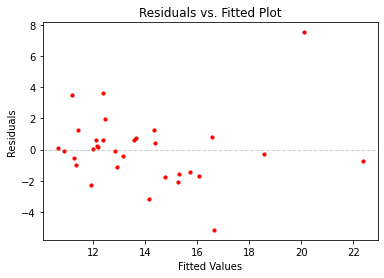

In [203]:
x_variables = [#'rtw_earnings_ratio_19',
               'log_Tourism_Spend_2009(£m)',
               #'log_RentsKm^2',
               '%Open_Space_2013']
multiple_regression(x_variables)

## K-Means Clustering

In [198]:
clustering_variables = ['rtw_earnings_ratio_19',
                        'log_Tourism_Spend_2009(£m)',
                        #'log_RentsKm^2',
                        '%Open_Space_2013',
                        'House_Earnings_Ratio']

In [199]:
clustering_data = full_data[clustering_variables] # We only want the coordinates for clustering

# I need the data to be on the same scale

std_clustering_data = pd.DataFrame()

std_clustering_data[clustering_variables] = StandardScaler().fit_transform(full_data[clustering_variables])

    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3


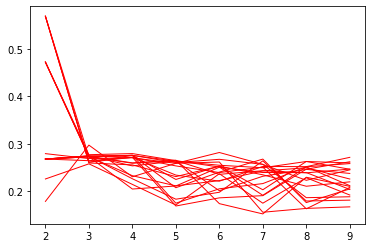

In [200]:
for i in range(1,20):
    kValues = []
    SilScores = []
    for k in range(2,10): # For k values between 2 and 10
        print(f'    ...k-value of {k}') # Update for the user
        kmeans_model = sklc.KMeans(n_clusters=k, n_init=1, random_state=i).fit(std_clustering_data) # Run the KMeans clustering algorithm
            #random_state is set for reproducibility
        labels = kmeans_model.labels_ # Extract the labels for each cluster the points belong to
        score = sklm.silhouette_score(std_clustering_data, labels, metric='euclidean') # Extract the average silhouette scores
        SilScores.append(score) # Add the score to the list
        kValues.append(k) # Add the k Value to the list
    plt.plot(kValues, SilScores, c='r', linewidth=1, linestyle='-')
plt.show()

In [201]:
mylist = [8,7,67,6,5,5,5,5,5]
mylist.index(max(mylist))

2

In [202]:
k = 3
reps = 50
scores = [0]
models = full_data

for model in range(1,reps):
    model_name = f'model_{model}'
    kmeans_model = sklc.KMeans(n_clusters=k, n_init=1, random_state=model).fit(std_clustering_data) # Run the KMeans clustering algorithm
                #random_state is set for reproducibility
    labels = kmeans_model.labels_ # Extract the labels for each cluster the points belong to
    models[model_name] = labels
    score = sklm.silhouette_score(std_clustering_data, labels, metric='euclidean') # Extract the average silhouette scores
    scores.append(score)
    print(f'Model {model}:\n   Average Silhouette Score: {score}')
    
max_index = scores.index(max(scores))
print(f'\nModel {max_index} had the highest average Silhouette Score: {scores[max_index]}')
for c in range(0,k):
    print(f'\nCluster {c+1}:\n')
    cluster_areas = models[(models[f'model_{max_index}'] == c)]
    print(cluster_areas['Area'].values)

Model 1:
   Average Silhouette Score: 0.2723368684752824
Model 2:
   Average Silhouette Score: 0.27417036366822883
Model 3:
   Average Silhouette Score: 0.27417036366822883
Model 4:
   Average Silhouette Score: 0.25744167714281685
Model 5:
   Average Silhouette Score: 0.26412343888289624
Model 6:
   Average Silhouette Score: 0.2723368684752824
Model 7:
   Average Silhouette Score: 0.29704312793535215
Model 8:
   Average Silhouette Score: 0.27417036366822883
Model 9:
   Average Silhouette Score: 0.27341751777919804
Model 10:
   Average Silhouette Score: 0.2608421552582214
Model 11:
   Average Silhouette Score: 0.27341751777919804
Model 12:
   Average Silhouette Score: 0.2723368684752824
Model 13:
   Average Silhouette Score: 0.2608421552582214
Model 14:
   Average Silhouette Score: 0.2768006547282586
Model 15:
   Average Silhouette Score: 0.2723368684752824
Model 16:
   Average Silhouette Score: 0.2723368684752824
Model 17:
   Average Silhouette Score: 0.26860476993030913
Model 18:
   A